In [ ]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

#own modules
from evaluation.utils import db
from evaluation.processing import tools_ec
from evaluation.visualization import plot
con = db.connect()
'done'

from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

        

<IPython.core.display.Javascript object>

Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (7479);
Done in  0:00:00.023360
 Control quality of HFR extraction: 


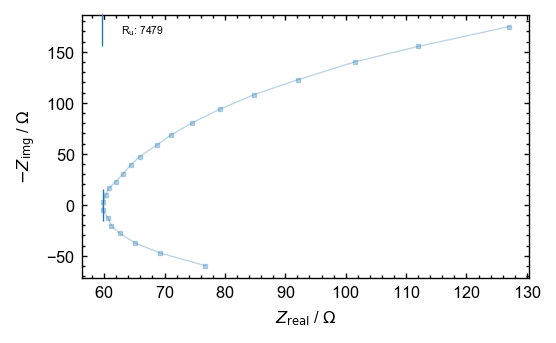

Matched experiment performed  9.887383333333334 min  earlier
Updated exp_ec with index: 7474 with ec_R_u_postdetermined__ohm= 59.8406  from id_exp_sfc= 7479
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_ec" ...
SELECT * FROM data_ec WHERE (`id_exp_sfc`) IN (7474) AND cycle IN (2);
Done in  0:00:00.026579
 This is just a basic implementation of ECSA calculation for single CV cycle on Pt with constant capacitive current correction in acidic electrolyte. Be aware analysis procedure need to be adjusted for different electrode material, electrolyte, ... 


/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:1196: UserWarning: y-axis label is overwritten from $I$ / A to I_capacitive__A
  warnings.warn('y-axis label is overwritten from ' + str(ax.get_ylabel()) + ' to ' + y_axislabel)


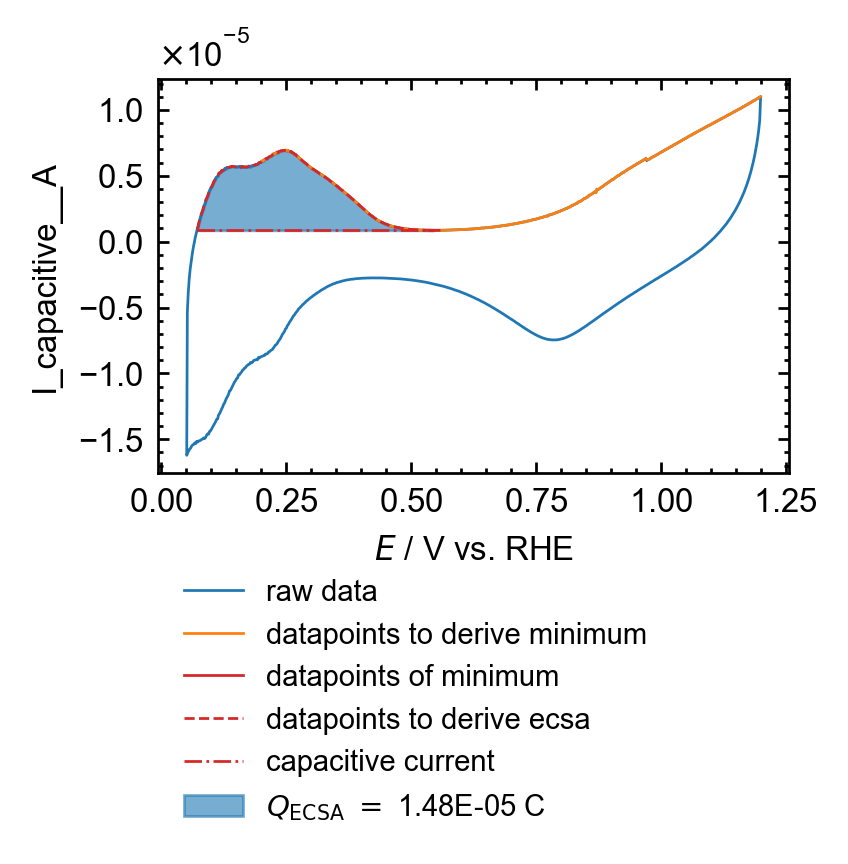

 File  20231009_processing_extracting.svg  already exists 


Overwrite?
	0: False
	1: True
Your choice:  0


 Nothing stored! 


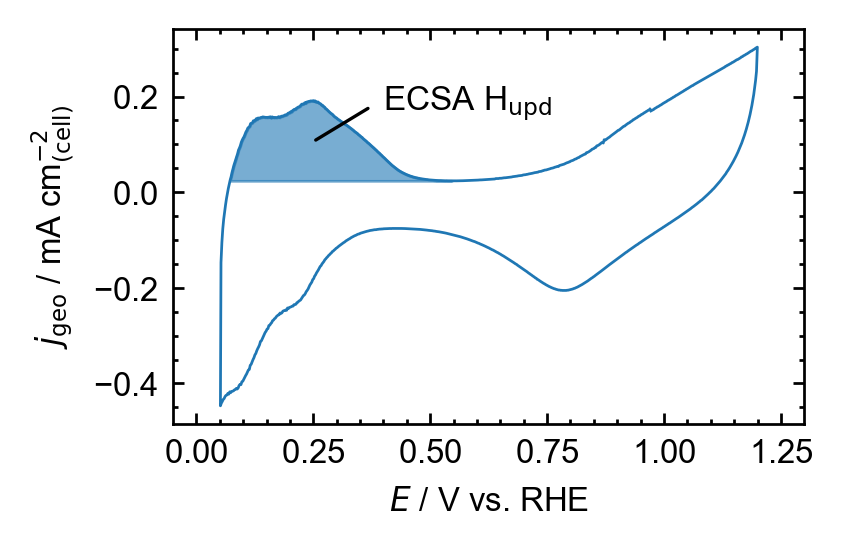

,name_user,name_setup_sfc,name_setup_sfc_alias,name_setup_sfc_feature,name_setup_sfc_type,t_start__timestamp,t_end__timestamp,rawdata_path,rawdata_computer,id_ML,id_ML_technique,id_sample,id_spot,force__N,T_stage__degC,interrupted,labview_sfc_version,db_version,comment,ec_name_technique,ec_R_u__ohm,ec_iR_corr_in_situ__percent,ec_R_u_determining_exp_ec,ec_E_RE__VvsRHE,ec_name_RE,ec_name_RE_material,ec_name_RE_manufacturer,ec_name_RE_model,ec_name_CE,ec_name_CE_material,ec_name_CE_manufacturer,ec_name_CE_model,ec_name_device,ec_id_control_mode,ec_id_ie_range,ec_id_vch_range,ec_id_ich_range,ec_id_vch_filter,ec_id_ich_filter,ec_id_ca_speed,ec_id_ie_stability,ec_id_sampling_mode,ec_ie_range_auto,ec_vch_range_auto,ec_ich_range_auto,samples_id_sample,samples_name_sample,samples_name_user,samples_t_manufactured__timestamp,samples_comment,samples_total_loading__mg_cm2,spots_id_spot,spots_spot_size__mm2,spots_pos_x__mm,spots_pos_y__mm,spots_comment,spots_total_loading__mg_cm2,cv_E_initial__VvsRE,cv_E_apex1__VvsRE,cv_E_apex2__VvsRE,cv_E_final__VvsRE,cv_scanrate__mV_s,cv_stepsize__mV,cv_cycles,geis_f_initial__Hz,geis_f_final__Hz,geis_I_dc__A,geis_I_amplitude__A,geis_R_initialguess__ohm,geis_points_per_decade,ghold_I_hold__A,ghold_t_hold__s,ghold_t_samplerate__s,peis_f_initial__Hz,peis_f_final__Hz,peis_E_dc__VvsRE,peis_E_amplitude__VvsRE,peis_R_initialguess__ohm,peis_points_per_decade,phold_E_hold__VvsRE,phold_t_hold__s,phold_t_samplerate__s,ppulse_E_hold1__VvsRE,ppulse_E_hold2__VvsRE,ppulse_t_hold1__s,ppulse_t_hold2__s,ppulse_t_samplerate__s,ppulse_cycles,gpulse_I_hold1__A,gpulse_I_hold2__A,gpulse_t_hold1__s,gpulse_t_hold2__s,gpulse_t_samplerate__s,gpulse_cycles,ramp_E_initial__VvsRE,ramp_E_final__VvsRE,ramp_scanrate__mV_s,ramp_stepsize__mV,ramp_cycles,fc_top_name_flow_cell,fc_top_name_flow_cell_name_user,fc_top_name_flow_cell_material,fc_top_name_flow_cell_A_opening_ideal__mm2,fc_top_name_flow_cell_A_opening_real__mm2,fc_top_name_flow_cell_manufacture_date,fc_top_name_flow_cell_CAD_file,fc_top_name_flow_cell_comment,fc_top_id_sealing,fc_top_id_sealing_name_user,fc_top_id_sealing_material,fc_top_id_sealing_A_sealing__mm2,fc_top_id_sealing_A_opening__mm2,fc_top_id_sealing_thickness__mm,fc_top_id_sealing_shaping_method,fc_top_id_sealing_comment,fc_top_id_PTL,fc_top_id_PTL_name_user,fc_top_id_PTL_material,fc_top_id_PTL_thickness__mm,fc_top_id_PTL_manufacturer,fc_top_id_PTL_A_PTL__mm2,fc_top_id_PTL_shaping_method,fc_top_id_PTL_comment,fc_bottom_name_flow_cell,fc_bottom_name_flow_cell_name_user,fc_bottom_name_flow_cell_material,fc_bottom_name_flow_cell_A_opening_ideal__mm2,fc_bottom_name_flow_cell_A_opening_real__mm2,fc_bottom_name_flow_cell_manufacture_date,fc_bottom_name_flow_cell_CAD_file,fc_bottom_name_flow_cell_comment,fc_bottom_id_sealing,fc_bottom_id_sealing_name_user,fc_bottom_id_sealing_material,fc_bottom_id_sealing_A_sealing__mm2,fc_bottom_id_sealing_A_opening__mm2,fc_bottom_id_sealing_thickness__mm,fc_bottom_id_sealing_shaping_method,fc_bottom_id_sealing_comment,fc_bottom_id_PTL,fc_bottom_id_PTL_name_user,fc_bottom_id_PTL_material,fc_bottom_id_PTL_thickness__mm,fc_bottom_id_PTL_manufacturer,fc_bottom_id_PTL_A_PTL__mm2,fc_bottom_id_PTL_shaping_method,fc_bottom_id_PTL_comment,fe_top_id_pump_in,fe_top_id_pump_in_manufacturer,fe_top_id_pump_in_model,fe_top_id_pump_in_device,fe_top_id_tubing_in,fe_top_id_tubing_in_name_tubing,fe_top_id_tubing_in_inner_diameter__mm,fe_top_id_tubing_in_color_code,fe_top_id_tubing_in_manufacturer,fe_top_id_tubing_in_model,fe_top_pump_rate_in__rpm,fe_top_id_pump_out,fe_top_id_pump_out_manufacturer,fe_top_id_pump_out_model,fe_top_id_pump_out_device,fe_top_id_tubing_out,fe_top_id_tubing_out_name_tubing,fe_top_id_tubing_out_inner_diameter__mm,fe_top_id_tubing_out_color_code,fe_top_id_tubing_out_manufacturer,fe_top_id_tubing_out_model,fe_top_pump_rate_out__rpm,fe_top_flow_rate_real__mul_min,fe_top_name_electrolyte,fe_top_c_electrolyte__mol_L,fe_top_T_electrolyte__degC,fe_bottom_id_pump_in,fe_bottom_id_pump_in_ma

In [2]:
name='20231009_processing_extracting'
exp_ec = db.get_exp('''SELECT  *
                        FROM hte_data.exp_ec_expanded 
                        WHERE name_user="n.roettcher"
                            AND name_setup_sfc = "SFC_1"
                            AND DATE(t_start__timestamp) = "2023-10-06"
                            
                            # if known simply select experiments by number of performed batch
                            # AND id_ML = 60 

                            # alternatively define by other metadata
                            AND fe_top_id_pump_out_device = 'SFC' # not connected to ICP-MS
                            AND fe_top_pump_rate_out__rpm = 0 # no electrolyte flow
                            AND ec_name_technique="exp_ec_cv"
                            AND cv_scanrate__mV_s = 100
                            AND ROUND(cv_E_apex1__VvsRE + ec_E_RE__VvsRHE, 1) = 1.2 # or 1.6
                        ;
                        ''')

exp_ec = tools_ec.update_R_u__ohm(exp_ec, match_eis_id_ML=61, user_control=False) # derive uncompensated resistance from EIS experiemtn performed in id_ML=61

data_ec = db.get_data(exp_ec, 'data_ec', add_cond = 'cycle IN (2)')
data_ec = tools_ec.compensate_R_u(exp_ec, data_ec) # calculate compensated potentials
data_ec = tools_ec.geometric_current(exp_ec, data_ec, geo_cols='fc_top_name_flow_cell_A_opening_ideal__mm2') # calculate geometric current density
exp_ec, data_ec = plot.get_j__mA_mg(exp_ec,
                                     data_ec,
                                     #j_geo_col='j_geo__mA_cm2geo_spot_size',
                                     )

exp_ec, data_ec = tools_ec.derive_ECSA(exp_ec, data_ec, method='Pt_Hupd_horizontal', geo_cols='fc_top_name_flow_cell_A_opening_ideal__mm2')



exp_ec_selected=exp_ec.sort_values(by='spots_comment').copy()
with plt.rc_context(plot.get_style(style='singleColumn',
                                   fig_size={'width':6, 'height':4},
                                   add_margins_and_figsize= {'left': 0.1,  },
                                   #interactive=True,
                                  )):
    plot_storage=plot.PlotDataStorage(name, overwrite_existing=True)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    exp_ec_selected = exp_ec_selected.dataset\
                    .plot(x_col='E_WE__VvsRHE',
                          y_col='j__mA_cm2geo_fc_top_cell_Aideal',
                          data=data_ec,  
                          ax=ax1,
                          label='normalized data',
                          color='tab:blue'
                        )\
                    .fill_between(x_col='E_WE__VvsRHE',
                          y_col= 'j_capacitive__mA_cm2geo_fc_top_cell_Aideal',
                          y2_col = 'j__mA_cm2geo_fc_top_cell_Aideal',
                          data=data_ec,    
                          ax=ax1,
                          label='ecsa',
                          color='tab:blue',
                          alpha=0.6,
                          axlabel_auto=False,   
                        )\
                    .return_dataset()


    
    ax1.annotate('ECSA H$_\mathrm{upd}$', 
                 xy=(0.24, 0.1), 
                 xytext=(0.4, 0.2),
                 xycoords='data',
                 fontsize=8,
                 arrowprops=dict(arrowstyle='-',lw=0.8,
                                 relpos=(0,0.6),
                                ),
                 va='center_baseline'
            )
    
    ax1.set_xlim([-0.05, 1.3])
    plot_storage.export(fig)
    plt.show()

exp_ec.dataset.display()